# Content Header

#### 1. Install Quandl Library 

#### 2. Find Data Set

#### 3. Make a subset, if necessary

#### 4. Create a line chart

#### 5. Decompose and Analyze results

#### 6. Conduct a Dickey-Fuller test for stationarity 

#### 7. Conduct a round of differencing, if not stationary

#### 8. repeat, if necessary

#### 9. Check autocorrelations


# 1. Installing Quandl

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

# 2. Importing data

In [4]:
# Configure API key 

quandl.ApiConfig.api_key = '9LFRxBYYRwo5E4MeCX7h' 

In [5]:
# Importing Data on Organization of the Petroleum Exporting Countries "OPEC Crude Oil Price" variable

data = quandl.get('OPEC/ORB')

In [6]:
data.head(5)

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [7]:
data.shape

(5321, 1)

In [8]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

# 4. Make a line chart of the data

Text(0.5, 1.0, 'OPEC Crude Oil Price Time Series')

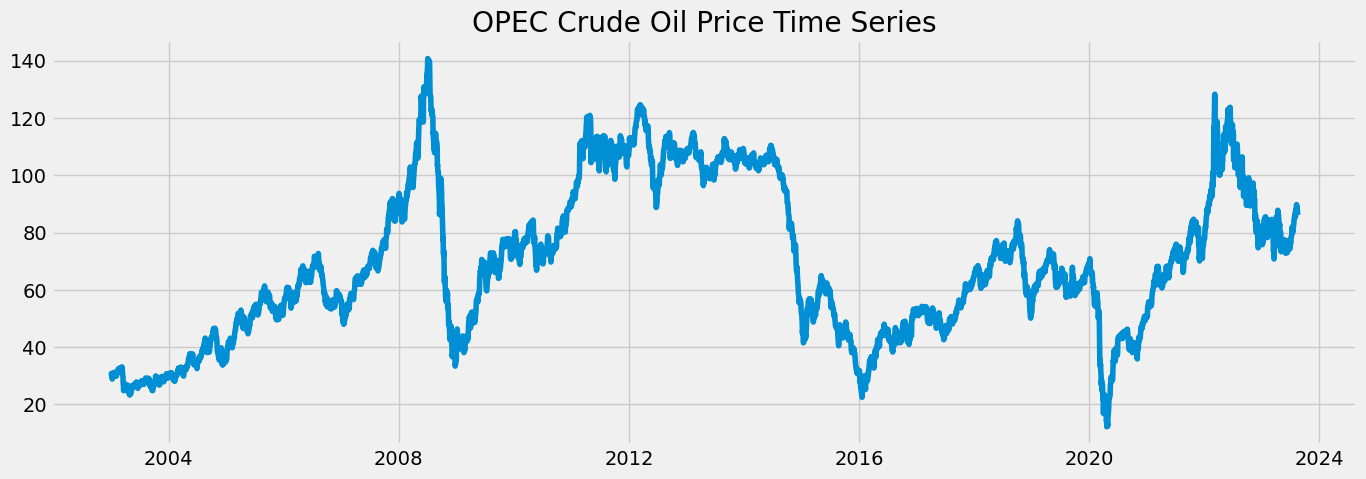

In [6]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)
plt.title('OPEC Crude Oil Price Time Series')

# 5. Decompose the data's components

In [11]:
data_2 = data.reset_index()

In [12]:
# Setting the "Date" column as the index

from datetime import datetime

data_2['datetime'] = pd.to_datetime(data_2['Date']) # Create a datetime column from "Date".
data_2 = data_2.set_index('datetime') # Set the datetime as the index of the dataframe.
data_2.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_2.head()

,Value
datetime,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [13]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_2, model='additive', period=1000)


In [14]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

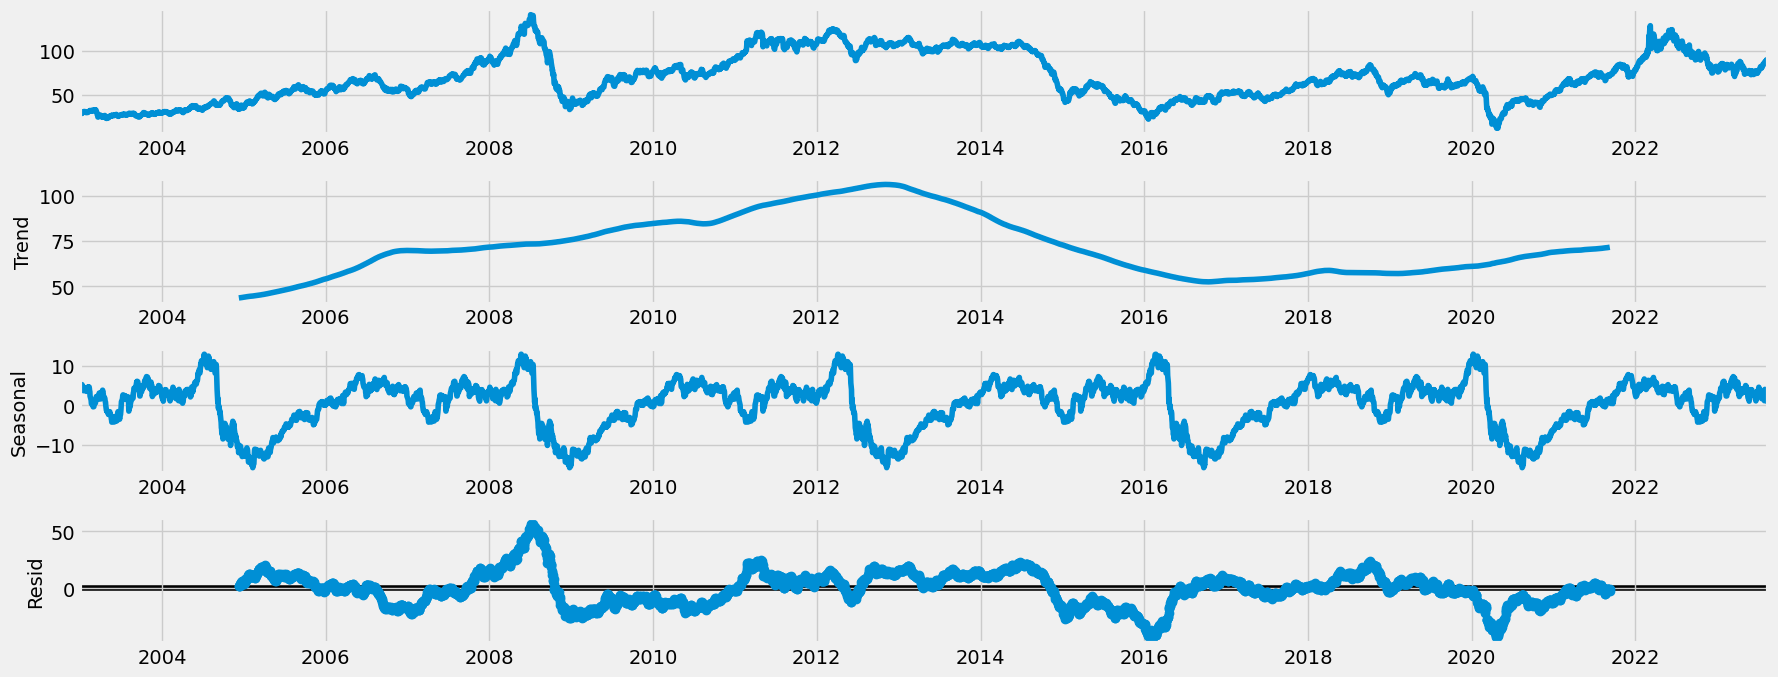

In [15]:
# Plot the separate components

decomposition.plot()
plt.show()

Trend: positive, goes up

Seasonality: Yes, the data does have seasonality

Stationarity: the data seems to go up since it has a trend. So I would say it is non-stationary.

# 6. check for stationarity. 

In [16]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.820138
p-value                           0.055454
Number of Lags Used              31.000000
Number of Observations Used    5289.000000
Critical Value (1%)              -3.431587
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


### The test statistic is smaller than the 10% critical value but bigger than the 5% and the 1%. Therefore, we cannot reject null hypothesis for a significance level of 5 or 1 percent.

### This tells us that the data is slightly non-stationary.

# 7. Differencing to stationarize the data

In [18]:
data_diff = data_2 - data_2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [19]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [20]:
data_diff.head()

,Value
datetime,
2003-01-03,0.78
2003-01-06,-0.12
2003-01-07,-0.99
2003-01-08,-0.86
2003-01-09,0.65


In [21]:
data_diff.columns

Index(['Value'], dtype='object')

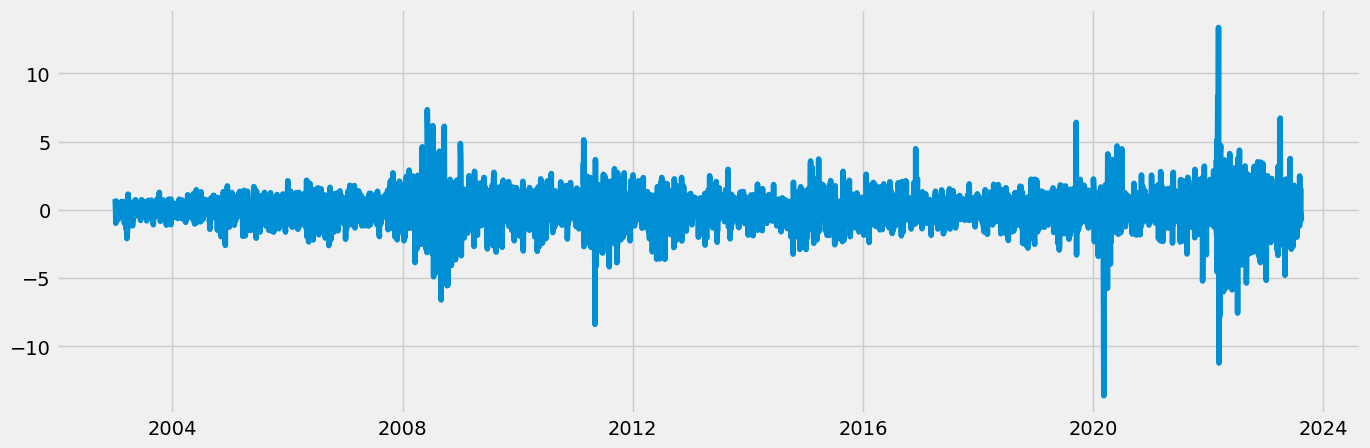

In [22]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [23]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.118771e+01
p-value                        2.411747e-20
Number of Lags Used            2.800000e+01
Number of Observations Used    5.291000e+03
Critical Value (1%)           -3.431587e+00
Critical Value (5%)           -2.862086e+00
Critical Value (10%)          -2.567061e+00
dtype: float64


### This definitely made the test statistic smaller than all 3 critical values. But, the chart looks strange and I wonder if something went wrong. 

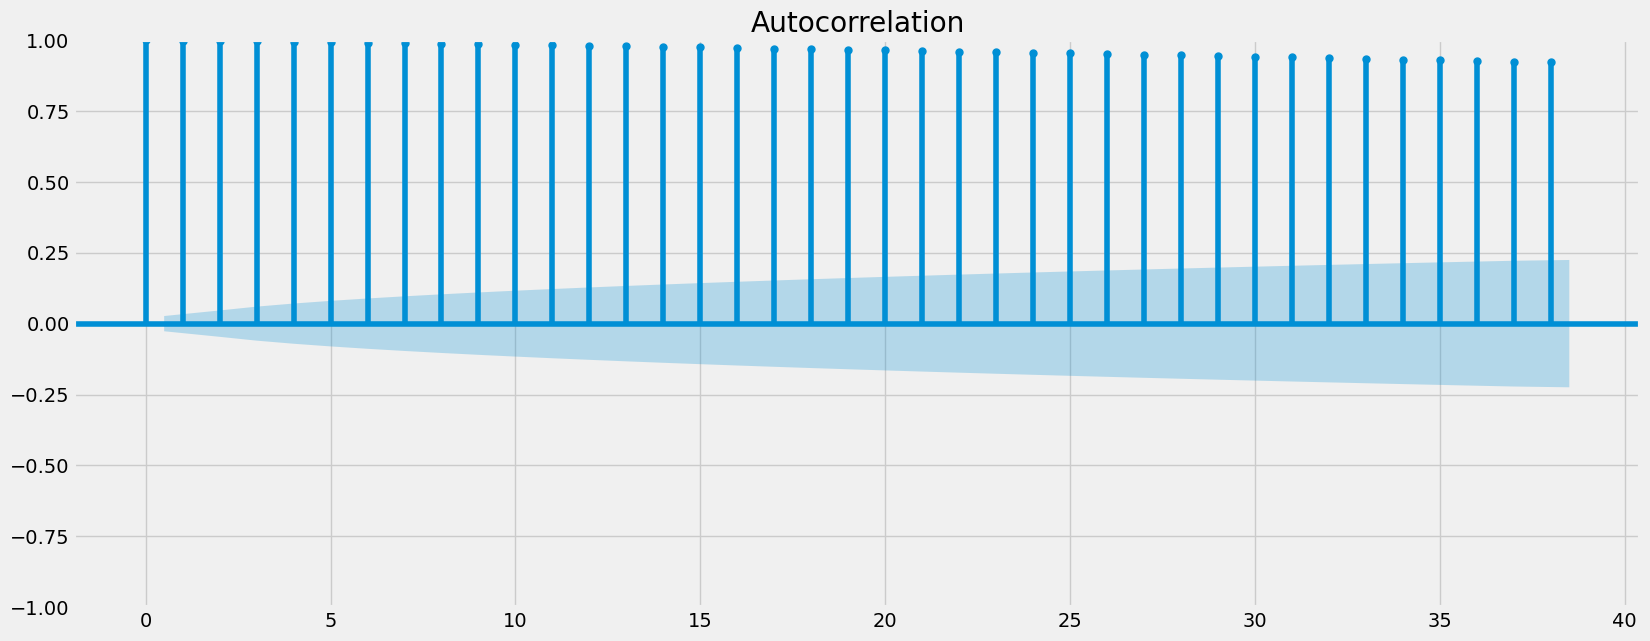

In [17]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_2)
plt.show()